**Segmentação semântica**

Arquitetura U-NET -> parecida com o autoencoder.

Segmentação de instâncias -> considera objetos do mesmo tipo de diferentes tipos.

Segmentação semântica -> os objetos de uma mesma classe são tratados da mesma forma.

Arquitetura U-Net pois tem o formato de U. Encoder > Decoder.

Autoencoder -> Utilizado para compactar imagens.

Codificação: Representa os recursos da imagem em vários níveis diferentes.

Decodificação: Projetar semanticamente as características da imagem conforme seu decodificador.

O maxpooling diminui as dimensões. O upsampling aumenta as dimemsões da imagem.

Ambas as segmentações estão sendo amplamente utilizadas na área médica.

In [2]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm # Gera barras de progresso durante a execução de algumas funções
from matplotlib import pyplot as plt
import tensorflow
import random 

In [3]:
# Ocultando avisos do colab durante a execução
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [15]:
os.environ['KAGGLE_USERNAME'] = 'lucasmacedo33'
os.environ['KAGGLE_KEY'] = '145ad444589c4b2a34514168115fb9a7'

In [18]:
! pip install -q kaggle 

In [20]:
# Download da base de dados
!kaggle competitions download -c data-science-bowl-2018

 99% 353M/358M [00:02<00:00, 133MB/s]
100% 358M/358M [00:02<00:00, 133MB/s]


In [21]:
!unzip /content/data-science-bowl-2018.zip

Archive:  /content/data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   


In [22]:
!unzip /content/stage1_train.zip -d /content/treinamento

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/treinamento/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/160cf18b03df69978e2ed33335afcd781ebebf4ee42df566aaa6fd0aee66ac93.png  
  inflating: /content/treinamento/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/16d3bf2426e9cda0e4f435de3a0c260d17be460f1c834c1282dfd68f9fcf7509.png  
  inflating: /content/treinamento/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1cfe69ef1dec8963e05ba8386a956af0073ba0bec2cc8ba534df81ef6dee905a.png  
  inflating: /content/treinamento/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1d2543cd2a8134ac2ca091a230bd15270826f8dd83c6594550b7f0fc85a15f8e.png  
  inflating: /content/treinamento/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/24b50e6e3406e513d47ddfa9bd85505a95a266858cffc730a9ad7bc99936b800.png  
  inflating: /content/treinamento/d35f25c8e3f7fca5232fc4d5e3f

In [24]:
!unzip /content/stage1_test.zip -d /content/teste

Archive:  /content/stage1_test.zip
   creating: /content/teste/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/
   creating: /content/teste/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac/
   creating: /content/teste/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/
   creating: /content/teste/0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925/
   creating: /content/teste/0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6/
   creating: /content/teste/0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466/
   creating: /content/teste/1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c/
   creating: /content/teste/17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff/
   creating: /content/teste/1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b/
   creating: /content/teste/191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829/
   creating: /content/tes

**Carreagamento e pré-processamento da imagem**

In [25]:
# As imagens não possuem dimensões iguais
largura = 256
altura = 256
canais = 3

seed = 42 # Números aleatorios
np.random.seed = seed
random.seed = seed

path_treinamento = '/content/treinamento/'
path_teste = '/content/teste/'

In [27]:
# Procurando o id da imagem
# Extraindo o nome dos arquivos (imagens)
train_ids = next(os.walk(path_treinamento))[1]
test_ids =  next(os.walk(path_teste))[1]

In [28]:
len(train_ids), len(test_ids)

(670, 65)

In [31]:
dataset_img = np.zeros((len(train_ids), altura, largura, canais), dtype = np.uint8)
dataset_mask = np.zeros((len(train_ids), altura, largura, 1), dtype = np.bool)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [32]:
dataset_img.shape, dataset_mask.shape

((670, 256, 256, 3), (670, 256, 256, 1))

**Pré-processamento**

União dos segmentos em uma mesma imagem

Segmentação semântica os objetos da mesma classe são tratados da mesma forma.

In [34]:
for n, id  in tqdm(enumerate(train_ids), total = len(train_ids)):
  path = path_treinamento + id

  if "." in path:
    continue

  img = cv2.imread(path + '/images/' + id + '.png')[:,:,:canais]
  img = cv2.resize(img, (altura, largura))
  dataset_img[n] = img

  mask = np.zeros((altura, largura, 1), dtype = np.bool)
  
  for mask_file in  next(os.walk(path + '/masks/'))[2]:
    mask_ = cv2.imread(path + '/masks/' + mask_file)
    mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY)
    mask_ = np.expand_dims(cv2.resize(mask_, (altura, largura)), axis = -1)

    mask = np.maximum(mask, mask_)
  
  dataset_mask[n] = mask

  0%|          | 0/670 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 670/670 [00:47<00:00, 14.08it/s]


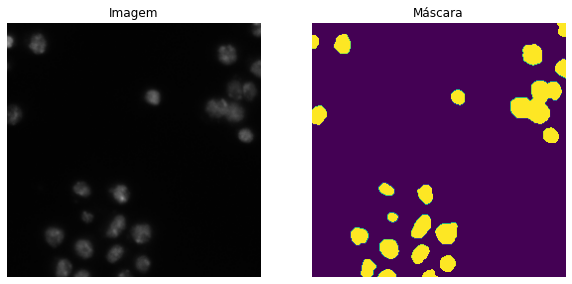

In [37]:
id = 6
fig = plt.figure(figsize=(10,7))

fig.add_subplot(1, 2, 1)
plt.imshow(dataset_img[id])
plt.axis('off')
plt.title('Imagem');

fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(dataset_mask[id]))
plt.axis('off')
plt.title('Máscara');

In [38]:
X_test = np.zeros((len(test_ids), altura, largura, canais), dtype = np.uint8)
redim_test = []

for n, id in tqdm(enumerate(test_ids), total = len(test_ids)):
  if "." in path:
    continue
  
  path = path_teste + id

  img = cv2.imread(path + '/images/' + id + '.png')[:,:,:canais]
  redim_test.append([img.shape[0], img.shape[1]])
  img = cv2.resize(img, (altura, largura))
  X_test[n] = img

100%|██████████| 65/65 [00:00<00:00, 216.79it/s]


In [39]:
# Divisão da base de dados

# Treinamento - base que a rede usa para aprender os pesos
# Validação - Para cada epóca da rede neural as imagens são submetidas a rede para obter o percentual de acerto parcial
# Teste - Usada para testar a rede ao final do treino da rede

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dataset_img, dataset_mask, test_size = 0.10, random_state = seed)

**Construção da rede neural**

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization # Permite normalizar os valores presentes em uma cadama
, Dropout, Lambda, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [45]:
def bloco_conv(input, num_filtros):
  x = Conv2D(num_filtros, 3, padding = 'same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filtros, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

In [46]:
# Encoder - convolução > MaxPooling
def bloco_encoder(input, num_filtros):
  x = bloco_conv(input, num_filtros)
  p = MaxPool2D((2, 2))(x)
  return x, p

In [47]:
# Decoder
def bloco_decoder(input, skip_features, num_filtros):
  x = Conv2DTranspose(num_filtros, (2,2), strides = 2, padding = 'same')(input)
  x = Concatenate()([x, skip_features])
  x = bloco_conv(x, num_filtros)
  return x

In [48]:
# União dos métodos
def modelo_unet(input_shape):
  inputs = Input(input_shape)

  s1, p1 = bloco_encoder(inputs, 64)
  s2, p2 = bloco_encoder(p1, 128)
  s3, p3 = bloco_encoder(p2, 256)
  s4, p4 = bloco_encoder(p3, 512)

  b1 = bloco_conv(p4, 1024)

  d1 = bloco_decoder(b1, s4, 512)
  d2 = bloco_decoder(d1, s3, 256)
  d3 = bloco_decoder(d2, s2, 128)
  d4 = bloco_decoder(d3, s1, 64)

  outputs = Conv2D(1, 1, padding = 'same', activation='sigmoid')(d4)

  model = Model(inputs, outputs, name = 'Unet' # Nome do modelo
  )

  return model

In [50]:
model = modelo_unet((altura, largura, canais))
model.compile(optimizer=Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                              

In [51]:
arquivo_modelo = 'modelo_unet.json'
modelo_json = model.to_json()

with open(arquivo_modelo, 'w') as json_file:
  json_file.write(modelo_json)

**Callbacks**

Permitem salvar a rede neural durante o treinamento

In [53]:
# Modelo será salvo sempre que houver aumento no valor do erro
nome_modelo = 'modelo_unet.h5'
chackpoint = ModelCheckpoint(nome_modelo, verbose = 1, save_best_only=True)
early_stopper = EarlyStopping(patience = 5, # Tolerância de que o modelo não melhora seu desempenho após 5 epócas, caso ele não melhore o treinamento é interrompido
                              monitor = 'val_loss')
callbacks = [chackpoint, early_stopper]   

In [54]:
epochs = 15
batch_size = 8 # Quantas imagens serão enviadas para a rede neural para ajustar os pesos

In [55]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks = [callbacks])

Epoch 1/15
76/76 [==============================] - ETA: 0s - loss: 0.3462 - accuracy: 0.8957
Epoch 1: val_loss improved from inf to 0.46500, saving model to modelo_unet.h5
76/76 [==============================] - 64s 569ms/step - loss: 0.3462 - accuracy: 0.8957 - val_loss: 0.4650 - val_accuracy: 0.9274
Epoch 2/15
76/76 [==============================] - ETA: 0s - loss: 0.1698 - accuracy: 0.9602
Epoch 2: val_loss improved from 0.46500 to 0.20927, saving model to modelo_unet.h5
76/76 [==============================] - 39s 519ms/step - loss: 0.1698 - accuracy: 0.9602 - val_loss: 0.2093 - val_accuracy: 0.9615
Epoch 3/15
76/76 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.9646
Epoch 3: val_loss improved from 0.20927 to 0.14697, saving model to modelo_unet.h5
76/76 [==============================] - 40s 529ms/step - loss: 0.1405 - accuracy: 0.9646 - val_loss: 0.1470 - val_accuracy: 0.9709
Epoch 4/15
76/76 [==============================] - ETA: 0s - loss: 0.1272 - 

In [56]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [57]:
def mostrar_graficos(history):
  fig = plt.gcf()

  fig.set_size_inches(16,4)
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], 'red', label = 'Acurácia treinamento')
  plt.plot(history.history['val_accuracy'], 'blue', label = 'Acurácia validação')
  plt.legend()
  plt.title('Acurácia')

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], 'red', label = 'Loss treinamento')
  plt.plot(history.history['val_loss'], 'blue', label = 'Loss validação')
  plt.legend()
  plt.title('Loss')

  plt.show();

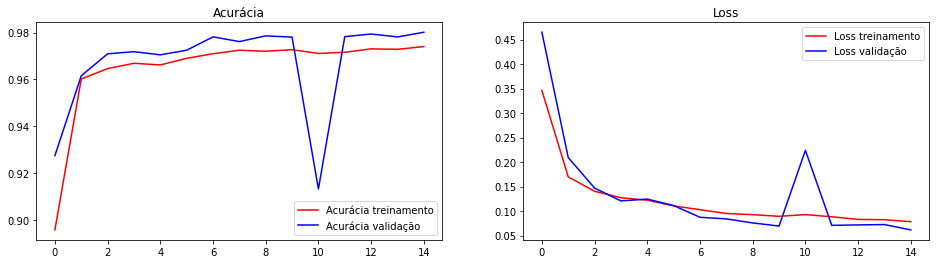

In [58]:
mostrar_graficos(history)

**Teste**

In [73]:
predicoes_val = model.predict(X_val)

In [74]:
predicoes_val = (predicoes_val > 0.5).astype(np.uint8)

In [64]:
def comparar_segmentacoes(original, ground_truth, predicao):
  fig = plt.figure(figsize=(12,7))

  fig.add_subplot(1,3,1)
  plt.imshow(original)
  plt.axis('off')
  plt.title('Imagem original')

  fig.add_subplot(1,3,2)
  plt.imshow(ground_truth)
  plt.axis('off')
  plt.title('Máscara real')

  fig.add_subplot(1,3,3)
  plt.imshow(predicao)
  plt.axis('off')
  plt.title('Predição')

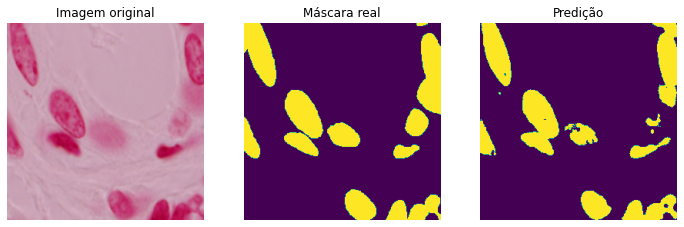

In [67]:
idx = 50
comparar_segmentacoes(X_val[idx], np.squeeze(y_val[idx]), np.squeeze(predicoes_val[idx]))

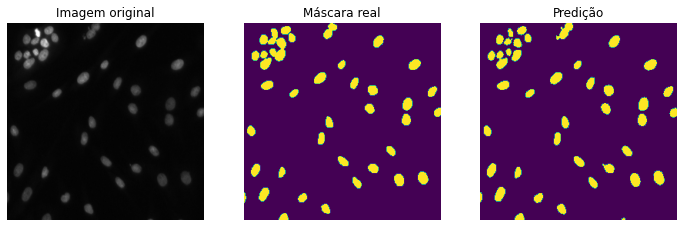

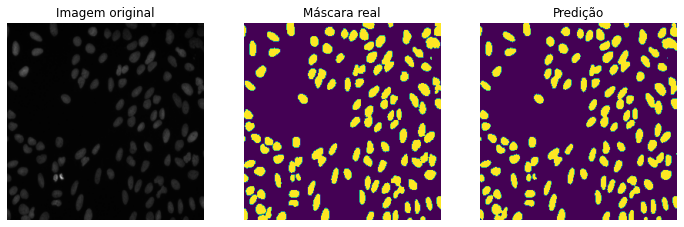

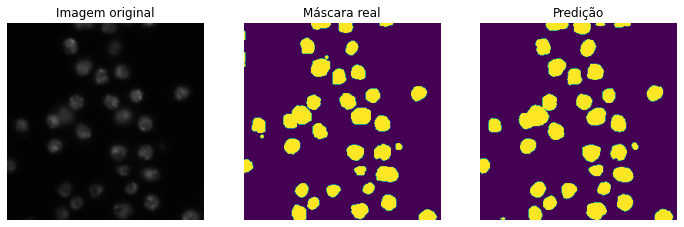

In [70]:
img_teste = np.random.choice(len(X_val), 3)

for img_id in img_teste:
  comparar_segmentacoes(X_val[img_id], np.squeeze(y_val[img_id]), np.squeeze(predicoes_val[img_id]))

In [75]:
predicoes_test = model.predict(X_test)
predicoes_test = (predicoes_test > 0.5).astype(np.uint8)

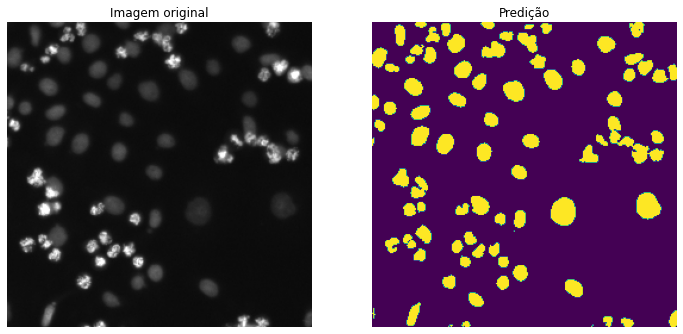

In [82]:
idx = random.randint(0, len(X_test))

fig = plt.figure(figsize=(12,7))

fig.add_subplot(1,2,1)
plt.imshow(X_test[idx])
plt.axis('off')
plt.title('Imagem original')

fig.add_subplot(1,2,2)
plt.imshow(np.squeeze(predicoes_test[idx]))
plt.axis('off')
plt.title('Predição');

**Métricas para avaliação**
- Área sobre união / índice de Jaccard: Quanto mais próximo de 1 melhor o resultado;
- Pixel accuracy: Porcentagem de pixels na imagem classificados corretamente. Pode sofrer com classes desbalanceadas.
- Dice coefficient (F1 Score): 2x a área de sobreposição dividida pelo número total de pixels em ambas as imagens. 2 * Interseção dos bouding boxes / sobre a soma das interseções. Dá um maior peso para a área de interseção. 

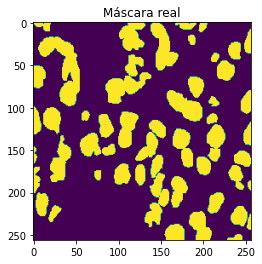

In [85]:
# IoU
id_teste = 0
img_teste = X_val[id_teste]
ground_truth = y_val[id_teste]

plt.imshow(np.squeeze(ground_truth))
plt.title('Máscara real');

In [86]:
from tensorflow.keras.metrics import MeanIoU
iou = MeanIoU(num_classes = 2)

In [87]:
test_img_input = np.expand_dims(img_teste, 0)
test_img_input.shape

(1, 256, 256, 3)

In [88]:
predicao = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

IoU =  0.879081


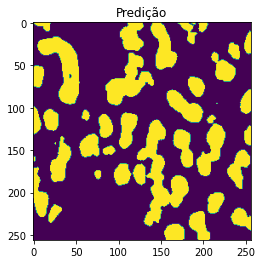

In [89]:
plt.imshow(predicao)
plt.title('Predição')
iou.update_state(ground_truth[:,:,0], predicao)
print('IoU = ', iou.result().numpy())

In [91]:
import pandas as pd

valores_IoU = []

for idx in range(0, X_val.shape[0]):
  img = X_val[idx]
  mask = y_val[idx]
  iou = MeanIoU(num_classes = 2)

  test_img = np.expand_dims(img, 0)
  predicao = (model.predict(test_img)[0,:,:,0] > 0.5).astype(np.uint8)
  iou.update_state(mask[:,:,0], predicao)
  iou_resultado = iou.result().numpy()

  valores_IoU.append(iou_resultado)
  print(iou_resultado)

0.879081
0.8944413
0.8970443
0.8058398
0.9168709
0.9735925
0.9635741
0.9256249
0.9097865
0.9729658
0.90178156
0.9365673
0.85149574
0.9701252
0.8410642
0.94570845
0.96290857
0.87526584
0.9303385
0.9577226
0.9100175
0.9158366
0.96482944
0.968855
0.9151249
0.9500276
0.94782674
0.95347846
0.8868804
0.95615757
0.7999151
0.96339333
0.9509352
0.9551696
0.83644325
0.9427157
0.9569075
0.9472467
0.8443715
0.94983625
0.95167613
0.90214634
0.97031486
0.96426976
0.9636111
0.9492936
0.96831465
0.9449253
0.9732462
0.81474364
0.8663298
0.76475644
0.8806523
0.95203495
0.91435707
0.9129014
0.88259506
0.9444499
0.9015113
0.84099364
0.88358355
0.89945006
0.92501986
0.8818074
0.97061366
0.9660902
0.93865925


In [92]:
df = pd.DataFrame(valores_IoU, columns = ['IoU'])
df = df[df.IoU != 1.0]
df

,IoU
0,0.879081
1,0.894441
2,0.897044
3,0.805840
4,0.916871
...,...
62,0.925020
63,0.881807
64,0.970614
65,0.966090


In [99]:
media_IoU = df.mean().values
media_IoU

array([0.918748], dtype=float32)

In [100]:
print('IoU média para ' + str(len(valores_IoU)) + ' imagens = ' + str(media_IoU))

IoU média para 67 imagens = [0.918748]


In [101]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [105]:
!cp /content/modelo_unet.h5 /content/drive/MyDrive/Mestrado/Cursos\ -\ Udemy/Segmentação\ de\ imagens/Redes_neurais/modelo_unet.h5
!cp /content/modelo_unet.json /content/drive/MyDrive/Mestrado/Cursos\ -\ Udemy/Segmentação\ de\ imagens/Redes_neurais/modelo_unet.json